# Week 9 Assignment: NLP Text classification

Create a NLP text classifier to predict whether a text message is spam. 

1) Load the dataset which includes 2 fields: (text and label) where label  indicates whether the message is “spam” or "not spam"  (eg: ham).

2) Perform basic EDA

3) Perform preprocessing of text (eg: lower-case, tokenization, removal of stop words, stemming/lemmatization, etc. as needed)

4) Vectorize Text (eg: BoW, TF-IDF, etc)

5) Create a model, using at least 2 different ML algorithms
    
 * Split the data into training and testing set
 * Train the model on training, then predict and assess performance on test
 * Predict custom messages (eg: your own custom message, at least 3) to evaluate how well your model categorized it

In [123]:
import string
import re

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import tree2conlltags
from nltk.chunk import conllstr2tree

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
df = pd.read_csv("spam.csv")

In [125]:
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [126]:
df['length'] = df.apply(lambda row: len(row.text), axis = 1)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
 2   length  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [128]:
df.describe()

,length
count,5572.000000
mean,80.118808
std,59.690841
min,2.000000
25%,36.000000
50%,61.000000
75%,121.000000
max,910.000000


<AxesSubplot:xlabel='label', ylabel='count'>

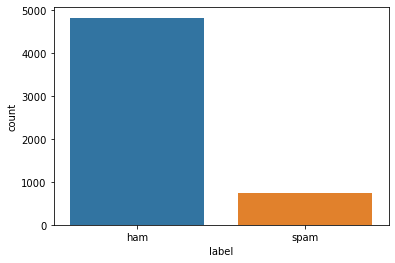

In [129]:
sns.countplot(x=df['label'])

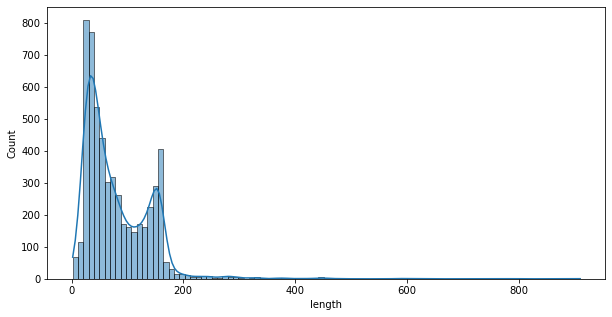

In [130]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='length', kde=True);

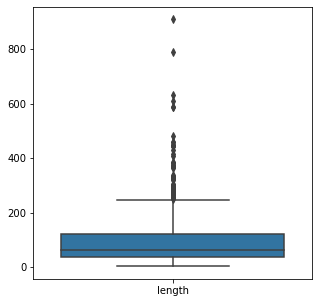

In [131]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df);

## Perform Data Cleaning

In [132]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, 
    remove numbers.'''
    text = text.lower()
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [134]:
# Let's take a look at the updated text
df = pd.DataFrame(df.text.apply(round1))
df

,text
0,"go until jurong point, crazy.. available only ..."
1,ok lar... joking wif u oni...
2,free entry in a wkly comp to win fa cup final...
3,u dun say so early hor... u c already then say...
4,"nah i don't think he goes to usf, he lives aro..."
...,...
5567,this is the time we have tried contact u. u ...
5568,will ì_ b going to esplanade fr home?
5569,"pity, * was in mood for that. so...any other s..."
5570,the guy did some bitching but i acted like i'd...


In [135]:
useless_words = stopwords.words("english") + list(string.punctuation)

In [136]:
df['text'] = [word for word in df['text'] if not word in useless_words]

In [137]:
for i in range(5):
    print(df_clean['text'][i])

go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...
ok lar... joking wif u oni...
free entry in  a wkly comp to win fa cup final tkts  may . text fa to  to receive entry question(std txt rate)t&c's apply 's
u dun say so early hor... u c already then say...
nah i don't think he goes to usf, he lives around here though


In [139]:
df['tokenized_text'] = df.apply(lambda row: word_tokenize(row['text']), axis=1)

In [140]:
df

,text,tokenized_text
0,"go until jurong point, crazy.. available only ...","[go, until, jurong, point, ,, crazy, .., avail..."
1,ok lar... joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, ..., u, c, alrea..."
4,"nah i don't think he goes to usf, he lives aro...","[nah, i, do, n't, think, he, goes, to, usf, ,,..."
...,...,...
5567,this is the time we have tried contact u. u ...,"[this, is, the, time, we, have, tried, contact..."
5568,will ì_ b going to esplanade fr home?,"[will, ì_, b, going, to, esplanade, fr, home, ?]"
5569,"pity, * was in mood for that. so...any other s...","[pity, ,, *, was, in, mood, for, that, ., so, ..."
5570,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,..."


In [141]:
df['tok_length'] = df.apply(lambda row: len(row.tokenized_text), axis = 1)

In [142]:
df

,text,tokenized_text,tok_length
0,"go until jurong point, crazy.. available only ...","[go, until, jurong, point, ,, crazy, .., avail...",24
1,ok lar... joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]",8
2,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ...",32
3,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, ..., u, c, alrea...",13
4,"nah i don't think he goes to usf, he lives aro...","[nah, i, do, n't, think, he, goes, to, usf, ,,...",15
...,...,...,...
5567,this is the time we have tried contact u. u ...,"[this, is, the, time, we, have, tried, contact...",29
5568,will ì_ b going to esplanade fr home?,"[will, ì_, b, going, to, esplanade, fr, home, ?]",9
5569,"pity, * was in mood for that. so...any other s...","[pity, ,, *, was, in, mood, for, that, ., so, ...",15
5570,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...",27


In [148]:
df['tokenized_text'][1]

['ok', 'lar', '...', 'joking', 'wif', 'u', 'oni', '...']